Trabajo Practico 2

In [41]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
from  collections  import defaultdict
from scipy import optimize
import os
from lectura import ldata
from math import log

In [2]:
# Red de interacciones binarias(yeast_Y2H.txt)
# Red de copertenecia o complejos proteícos(yeast_AP-MS.txt)
# Red obtenida de literatura: Yeast Interactome Database(yeast_LIT.txt)

In [42]:
# El directorio que vamos a usar en cada lectura de datos de ahora en mas
directorio = os.path.dirname(os.path.realpath("yeast_AP-MS.txt"))

In [43]:
fnMS = os.path.join(directorio,'tc02Data/yeast_AP-MS.txt')
fnLIT = os.path.join(directorio,'tc02Data/yeast_LIT.txt')
fnY2H = os.path.join(directorio,'tc02Data/yeast_Y2H.txt')
fnLIT_reg = os.path.join(directorio,'tc02Data/yeast_LIT_Reguly.txt')

# Lectura de datos
datosapms=ldata(fnMS)
datoslit=ldata(fnLIT)
datosy2h=ldata(fnY2H)
datoslit_reg=ldata(fnLIT_reg)
datoslit_reg=[row[0:2] for row in datoslit_reg][1:]


In [44]:
G1 = nx.Graph()
G2 = nx.Graph()
G3 = nx.Graph()
G4 = nx.Graph()

G1.add_edges_from(datosapms)
G2.add_edges_from(datoslit)
G3.add_edges_from(datosy2h)
G4.add_edges_from(datoslit_reg)



In [45]:
# Características de las redes

# Numero total de nodos
N = [G1.number_of_nodes(),G2.number_of_nodes(),G3.number_of_nodes(),G4.number_of_nodes()]

# Numero total de enlaces
L = [G1.number_of_edges(),G2.number_of_edges(),G3.number_of_edges(),G4.number_of_edges()]

# Grado medio
kmean = [np.mean(list(dict(G1.degree).values())),np.mean(list(dict(G2.degree).values())),
         np.mean(list(dict(G3.degree).values())),
         np.mean(list(dict(G4.degree).values()))]

# Coeficiente de clustering local
clusteringlocal = [nx.average_clustering(G1),nx.average_clustering(G2),nx.average_clustering(G3),nx.average_clustering(G4)]


In [46]:
# Tabla con las caraterísticas de las redes
info= pd.DataFrame({"ID":['apms','YID_lit','y2h','lit_reg'],"nodos":N,"enlaces":L,"kmean":kmean,
                    "clusteringlocal":clusteringlocal})

In [47]:
info

,ID,nodos,enlaces,kmean,clusteringlocal
0,apms,1622,9070,11.183724,0.554636
1,YID_lit,1536,2925,3.808594,0.292492
2,y2h,2018,2930,2.903865,0.046194
3,lit_reg,3307,11858,7.171454,0.261134


In [48]:
def overlap(red1,red2):
    cant=0
    for edge in red1.edges():
        if edge in red2.edges():
            cant+=1
            
    return cant/red1.number_of_edges()

In [49]:
overlap(G1,G2)

0.14310915104740904

In [50]:
nombres=['apms','YID_lit','y2h','lit_reg']
grafos=[G1,G2,G3,G4]
columna=[0]*4
for j in np.arange(4):
    columna[j]=[0,0,0,0]
    for i in np.arange(4):
        if i==j:
            columna[j][i]=nombres[i]
        else:
            columna[j][i]=overlap(grafos[i],grafos[j])
            
tabla2=pd.DataFrame(columna)

In [51]:
tabla2

,0,1,2,3
0,apms,0.443761,0.0887372,0.212515
1,0.143109,YID_lit,0.0887372,0.241187
2,0.0286659,0.0888889,y2h,0.0403947
3,0.277839,0.977778,0.163481,lit_reg


In [52]:
fnessential = os.path.join(directorio,'tc02Data/Essential_ORFs_paperHe.txt')
essential=ldata(fnessential)
essential=[row[1] for row in essential[2:-4]]

In [53]:
def essentialhubs(grafo,essential):
    Nodos=sorted(grafo.degree, key=lambda x: x[1], reverse=True)
    CantidadHubs=np.arange(len(Nodos)+1)
    CantidadEssential=[0]
    PorcEssential=[0]
    contador=1
    for nodo in Nodos:
        if nodo[0] in essential:
            CantidadEssential.append(CantidadEssential[-1]+1)
        else:
            CantidadEssential.append(CantidadEssential[-1])
        PorcEssential.append(CantidadEssential[-1]/CantidadHubs[contador])
        #print(CantidadHubs[contador],contador)
        contador+=1
    CantidadHubs=np.array(CantidadHubs)/len(Nodos)
    return [CantidadHubs,PorcEssential]

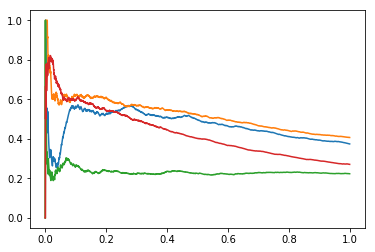

In [54]:
for i in np.arange(4):
    cantidad,esencial=essentialhubs(grafos[i],essential)
    
    plt.plot(cantidad,esencial)   
plt.show()

In [16]:
#.degree
#eigenvector_centrality(G, max_iter=100, tol=1e-06, nstart=None, weight=None)
#subgraph_centrality(G)
#betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None)
#current_flow_closeness_centrality(G, weight='weight', dtype=<type 'float'>, solver='lu')
#len(max(nx.connected_component_subgraphs(G1), key=len).nodes())

In [55]:
import random

In [16]:
def vulnerability(Grafo,essential):
    randomlist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    #El primer cuarto del grafo, sacamos de a 10 nodos por cada vez que elegimos la compontente mayor
    while len(G)>len(Grafo)*3/4:
            componente=max(nx.connected_component_subgraphs(G), key=len) #Elegimos componente
            randomlist.append(len(componente)/tamaño) # tamaño de la componente (normalizado)
            fraccion.append(i/tamaño) #Cantidad de nodos que sacamos (normalizado)
            for j in np.arange(10): #Elegimos el proximo nodo a sacar
                nodo=random.choice(list(componente.nodes())) 
                G.remove_node(nodo)
                componente.remove_node(nodo)
                i+=1
    #El segundo cuarto sacamos nodos eligiendo en cada paso la componente mayor. Paramos cuando el grafo está a la mitad de su tamaño original
    while len(G)>len(Grafo)/2:
            componente=max(nx.connected_component_subgraphs(G), key=len)
            randomlist.append(len(componente)/tamaño)
            fraccion.append(i/tamaño)
            nodo=random.choice(list(componente.nodes()))
            G.remove_node(nodo)
            i+=1

    return fraccion,randomlist

In [17]:
def vulnerabilitygrado(Grafo,essential):
    gradolist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
#    Nodos=sorted(G.degree, key=lambda x: x[1], reverse=True)
    while len(G)>len(Grafo)*3/4:
            componente=max(nx.connected_component_subgraphs(G), key=len)
            gradolist.append(len(componente)/tamaño)
            fraccion.append(i/tamaño)
            for j in np.arange(10):
                nodo=max(componente.degree)
                G.remove_node(nodo[0])
                componente.remove_node(nodo[0])
                i+=1
    while len(G)>len(Grafo)/2:
            componente=max(nx.connected_component_subgraphs(G), key=len)
            gradolist.append(len(componente)/tamaño)
            fraccion.append(i/tamaño)
            nodo=max(componente.degree)
            G.remove_node(nodo[0])

            i+=1

    return fraccion,gradolist

In [18]:
def vulnerabilityautovec(Grafo,essential):
    autoveclist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    while len(G)>len(Grafo)*3/4:
            componente=max(nx.connected_component_subgraphs(G), key=len)
            autoveclist.append(len(componente)/tamaño)
            fraccion.append(i/tamaño)
            for j in np.arange(10):
                nodo=max(nx.eigenvector_centrality_numpy(componente,max_iter=70)) #le puse_numpy por sug de la fucnion
                G.remove_node(nodo)
                componente.remove_node(nodo)
                i+=1    
    while len(G)>len(Grafo)/2:
        componente=max(nx.connected_component_subgraphs(G), key=len)
        autoveclist.append(len(componente)/tamaño)
        fraccion.append(i/tamaño)
        nodo=max(nx.eigenvector_centrality_numpy(componente,max_iter=70))
        G.remove_node(nodo)
        i+=1
    return fraccion,autoveclist

In [19]:
def vulnerabilitysubgraph(Grafo,essential):
    subgraphlist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    while len(G)>len(Grafo)*3/4:
            componente=max(nx.connected_component_subgraphs(G), key=len)
            subgraphlist.append(len(componente)/tamaño)
            fraccion.append(i/tamaño)
            for j in np.arange(10):
                nodo=max(nx.subgraph_centrality(componente))
                G.remove_node(nodo)
                componente.remove_node(nodo)
                i+=1
    while len(G)>len(Grafo)/2:
        componente=max(nx.connected_component_subgraphs(G), key=len)
        subgraphlist.append(len(componente)/tamaño)
        fraccion.append(i/tamaño)
        nodo=max(nx.subgraph_centrality(componente))
        G.remove_node(nodo)
        i+=1
    return fraccion,subgraphlist

In [20]:
def vulnerabilitybetweeness(Grafo,essential):
    betweenesslist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    while len(G)>len(Grafo)*3/4:
            componente=max(nx.connected_component_subgraphs(G), key=len)
            betweenesslist.append(len(componente)/tamaño)
            fraccion.append(i/tamaño)
            for j in np.arange(10):
                nodo=max(nx.betweenness_centrality(componente, k=None, normalized=True, weight=None, endpoints=False, seed=None))
                componente.remove_node(nodo)
                G.remove_node(nodo)
                i+=1    
    while len(G)>len(Grafo)/2:
        componente=max(nx.connected_component_subgraphs(G), key=len)
        betweenesslist.append(len(componente)/tamaño)
        fraccion.append(i/tamaño)
        nodo=max(nx.betweenness_centrality(componente, k=None, normalized=True, weight=None, endpoints=False, seed=None))
        G.remove_node(nodo)
        i+=1
    return fraccion,betweenesslist

In [21]:
def vulnerabilityflow(Grafo,essential):
    flowlist=[]
    fraccion=[]
    tamaño=len(list(Grafo.nodes()))
    G=Grafo.copy()
    i=0
    Nodos=sorted(nx.current_flow_closeness_centrality(max(nx.connected_component_subgraphs(G), key=len), weight=None, solver='lu'), key=lambda x: x[1], reverse=True)
  
    while len(G)>len(Grafo)/2:
        componente=max(nx.connected_component_subgraphs(G), key=len)
        flowlist.append(len(componente)/tamaño)
        fraccion.append(i/tamaño)
        nodo=max(nx.current_flow_closeness_centrality(componente))
        G.remove_node(nodo)
        i+=1
    return fraccion,flowlist

In [22]:
def vulnerabilityessential(Grafo,essential):
    G=Grafo.copy()
    tamaño=len(list(Grafo.nodes()))
    for nodo in Grafo.nodes():
        if nodo in essential:
            G.remove_node(nodo)
            
    essential=len(max(nx.connected_component_subgraphs(G), key=len).nodes())/tamaño
    fraccion3=(len(Grafo)-len(G))/tamaño

    return fraccion3,essential,len(Grafo)-len(G)

In [ ]:
#No correr estos, salvo que queramos probar uno por uno

In [25]:
#f1,lc=vulnerability(G1,essential)

In [27]:
f2,vgrado=vulnerabilitygrado(G1,essential)

In [32]:
f3,lcautovec=vulnerabilityautovec(G1,essential)

In [33]:
f4,lcsubgraph=vulnerabilitysubgraph(G1,essential)

In [26]:
#f5,lcbetweeness=vulnerabilitybetweeness(G1,essential)

In [27]:
#f6,lcflow=vulnerabilityflow(G1,essential)

In [36]:
f7,lcessential,cant=vulnerabilityessential(G1,essential)

In [61]:
#Todo Junto
G=G2 #Hay que cambiar para hacer el de otros graficos
#Para el metodo random realizamos 10 iteraciones y elegimos el promedio de todas
lcs=[]
for i in np.arange(3):
    f1,lista=vulnerability(G,essential)    #el error estaba aquí estaba corriendo todo en base a G1
    lcs.append(lista)
lc=[np.mean(a) for a in list((zip(lcs[0],lcs[1],lcs[2])))]
"""
#El resto de los metodos
f2,vgrado=vulnerabilitygrado(G,essential)
#f3,lcautovec=vulnerabilityautovec(G,essential)
f4,lcsubgraph=vulnerabilitysubgraph(G,essential)
f5,lcbetweeness=vulnerabilitybetweeness(G,essential)
f6,lcflow=vulnerabilityflow(G,essential)
f7,lcessential,cant=vulnerabilityessential(G,essential)
"""

'\n#El resto de los metodos\nf2,vgrado=vulnerabilitygrado(G,essential)\n#f3,lcautovec=vulnerabilityautovec(G,essential)\nf4,lcsubgraph=vulnerabilitysubgraph(G,essential)\nf5,lcbetweeness=vulnerabilitybetweeness(G,essential)\nf6,lcflow=vulnerabilityflow(G,essential)\nf7,lcessential,cant=vulnerabilityessential(G,essential)\n'

In [62]:
#El resto de los metodos
f2,vgrado=vulnerabilitygrado(G,essential)
print ("f2")
f3,lcautovec=vulnerabilityautovec(G,essential)
print ("f3")
f4,lcsubgraph=vulnerabilitysubgraph(G,essential)
print ("f4")
f5,lcbetweeness=vulnerabilitybetweeness(G,essential)
print ("f5")
f6,lcflow=vulnerabilityflow(G,essential)
print ("f6")
f7,lcessential,cant=vulnerabilityessential(G,essential)
print ("f7")

f2
f3
f4
f5
f6
f7


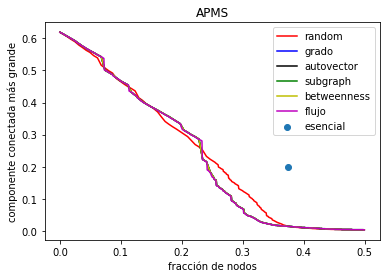

In [35]:

plt.plot(f1,lc,"r", label='random')
plt.plot(f2,vgrado,"b", label='grado')
plt.plot(f3,lcautovec,"k", label='autovector')
plt.plot(f4,lcsubgraph,"g", label='subgraph')
plt.plot(f5,lcbetweeness,"y", label='betweenness')
plt.plot(f6,lcflow,"m", label='flujo')
plt.scatter(f7,lcessential, label='esencial')
plt.xlabel("fracción de nodos")
plt.ylabel("componente conectada más grande")
plt.legend()
plt.title("APMS")
plt.show()

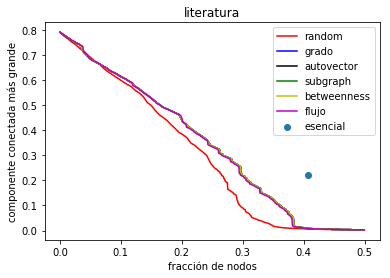

In [63]:

plt.plot(f1,lc,"r", label='random')
plt.plot(f2,vgrado,"b", label='grado')
plt.plot(f3,lcautovec,"k", label='autovector')
plt.plot(f4,lcsubgraph,"g", label='subgraph')
plt.plot(f5,lcbetweeness,"y", label='betweenness')
plt.plot(f6,lcflow,"m", label='flujo')
plt.scatter(f7,lcessential, label='esencial')
plt.xlabel("fracción de nodos")
plt.ylabel("componente conectada más grande")
plt.legend()
plt.title("literatura")
plt.show()

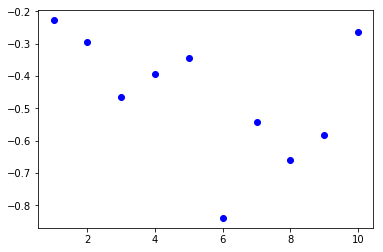

In [23]:
# Figura 2b  de HE (2006)

Grafo=G1.copy()
HEnorm={}
HEessencial={}
for nodo in Grafo.nodes():
    grado=Grafo.degree(nodo)
    if grado<11:
        try:
            HEnorm[grado]+=1
        except:
            HEnorm[grado]=1

        if nodo in essential:
            try:
                HEessencial[grado]+=1
            except:
                HEessencial[grado]=1

Porc={}
for i in sorted(HEnorm.keys()):
    try:
        Porc[i]=log(1-(HEessencial[i]/HEnorm[i]))
    except:
        Porc[i]=log(1)
plt.plot(list(Porc.keys()),list(Porc.values()),'bo')
plt.show()

-0.31963328498076327 -0.02574150485585447
0.1699727594907313


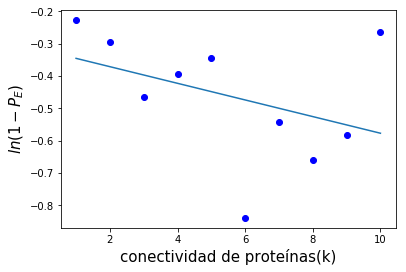

In [24]:

# Ajuste de la recta

datox=np.array(list(Porc.keys()))
datoy=np.array(list(Porc.values()))

fitfunc = lambda p, x: p[0] + x* p[1] 
errfunc = lambda p, x, y: (y - fitfunc(p, x)) 

pinit = [1, 1]
out = optimize.leastsq(errfunc, pinit,  args=(datox,datoy), full_output=1)
pfinal = out[0]

rms = np.sqrt(np.mean(errfunc(pfinal,datox,datoy)**2))

print(pfinal[0],pfinal[1])
print(rms)

recta=[fitfunc(pfinal,x) for x in datox ]

plt.clf()
plt.plot(datox,datoy,'bo')
plt.plot(datox, recta)     # Fit
plt.xlabel("conectividad de proteínas(k)",fontsize = 15)
plt.ylabel('$ln(1-P_E)$', fontsize = 15)
#plt.anotate(poner el valor del Ln,r y p)
plt.show()

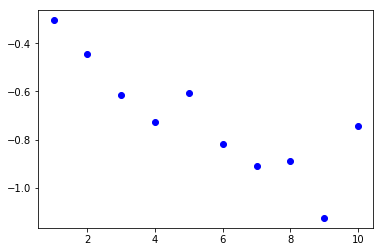

In [45]:
# Figura 2b  de HE (2006)

Grafo=G2.copy()
HEnorm={}
HEessencial={}
for nodo in Grafo.nodes():
    grado=Grafo.degree(nodo)
    if grado<11:
        try:
            HEnorm[grado]+=1
        except:
            HEnorm[grado]=1

        if nodo in essential:
            try:
                HEessencial[grado]+=1
            except:
                HEessencial[grado]=1

Porc={}
for i in sorted(HEnorm.keys()):
    try:
        Porc[i]=log(1-(HEessencial[i]/HEnorm[i]))
    except:
        Porc[i]=log(1)
plt.plot(list(Porc.keys()),list(Porc.values()),'bo')
plt.show()

-0.3565784955250653 -0.06567075332715429
0.12495457187725796


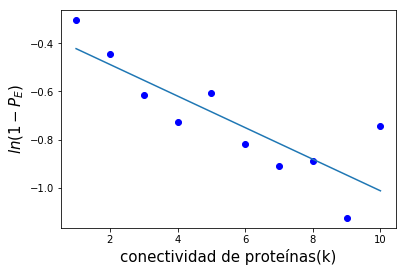

In [46]:

# Ajuste de la recta

datox=np.array(list(Porc.keys()))
datoy=np.array(list(Porc.values()))

fitfunc = lambda p, x: p[0] + x* p[1] 
errfunc = lambda p, x, y: (y - fitfunc(p, x)) 

pinit = [1, 1]
out = optimize.leastsq(errfunc, pinit,  args=(datox,datoy), full_output=1)
pfinal = out[0]

rms = np.sqrt(np.mean(errfunc(pfinal,datox,datoy)**2))

print(pfinal[0],pfinal[1])
print(rms)

recta=[fitfunc(pfinal,x) for x in datox ]

plt.clf()
plt.plot(datox,datoy,'bo')
plt.plot(datox, recta)     # Fit
plt.xlabel("conectividad de proteínas(k)",fontsize = 15)
plt.ylabel('$ln(1-P_E)$', fontsize = 15)
#plt.anotate(poner el valor del Ln,r y p)
plt.show()

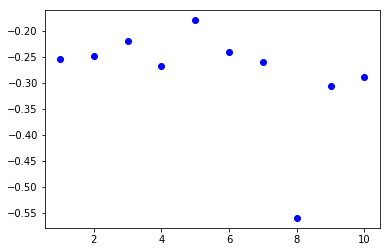

In [47]:
# Figura 2b  de HE (2006)

Grafo=G3.copy()
HEnorm={}
HEessencial={}
for nodo in Grafo.nodes():
    grado=Grafo.degree(nodo)
    if grado<11:
        try:
            HEnorm[grado]+=1
        except:
            HEnorm[grado]=1

        if nodo in essential:
            try:
                HEessencial[grado]+=1
            except:
                HEessencial[grado]=1

Porc={}
for i in sorted(HEnorm.keys()):
    try:
        Porc[i]=log(1-(HEessencial[i]/HEnorm[i]))
    except:
        Porc[i]=log(1)
plt.plot(list(Porc.keys()),list(Porc.values()),'bo')
plt.show()

-0.2010985669614651 -0.01476431875782036
0.08853312790810401


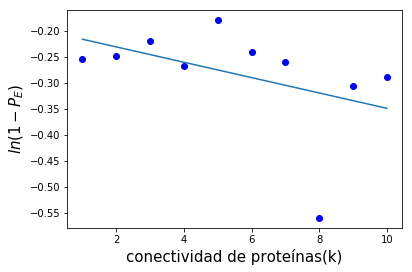

In [48]:

# Ajuste de la recta

datox=np.array(list(Porc.keys()))
datoy=np.array(list(Porc.values()))

fitfunc = lambda p, x: p[0] + x* p[1] 
errfunc = lambda p, x, y: (y - fitfunc(p, x)) 

pinit = [1, 1]
out = optimize.leastsq(errfunc, pinit,  args=(datox,datoy), full_output=1)
pfinal = out[0]

rms = np.sqrt(np.mean(errfunc(pfinal,datox,datoy)**2))

print(pfinal[0],pfinal[1])
print(rms)

recta=[fitfunc(pfinal,x) for x in datox ]

plt.clf()
plt.plot(datox,datoy,'bo')
plt.plot(datox, recta)     # Fit
plt.xlabel("conectividad de proteínas(k)",fontsize = 15)
plt.ylabel('$ln(1-P_E)$', fontsize = 15)
#plt.anotate(poner el valor del Ln,r y p)
plt.show()

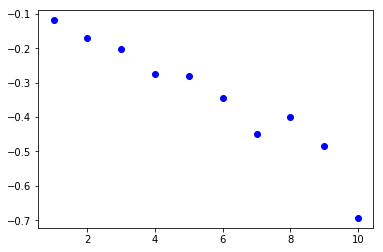

In [49]:
# Figura 2b  de HE (2006)

Grafo=G4.copy()
HEnorm={}
HEessencial={}
for nodo in Grafo.nodes():
    grado=Grafo.degree(nodo)
    if grado<11:
        try:
            HEnorm[grado]+=1
        except:
            HEnorm[grado]=1

        if nodo in essential:
            try:
                HEessencial[grado]+=1
            except:
                HEessencial[grado]=1

Porc={}
for i in sorted(HEnorm.keys()):
    try:
        Porc[i]=log(1-(HEessencial[i]/HEnorm[i]))
    except:
        Porc[i]=log(1)
plt.plot(list(Porc.keys()),list(Porc.values()),'bo')
plt.show()

-0.043769407910835056 -0.05420421216918925
0.048158638288934706


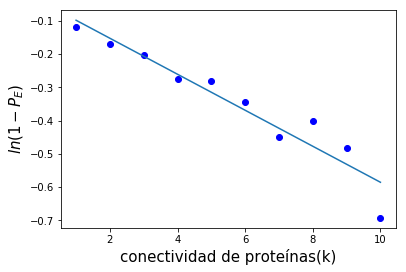

In [50]:

# Ajuste de la recta

datox=np.array(list(Porc.keys()))
datoy=np.array(list(Porc.values()))

fitfunc = lambda p, x: p[0] + x* p[1] 
errfunc = lambda p, x, y: (y - fitfunc(p, x)) 

pinit = [1, 1]
out = optimize.leastsq(errfunc, pinit,  args=(datox,datoy), full_output=1)
pfinal = out[0]

rms = np.sqrt(np.mean(errfunc(pfinal,datox,datoy)**2))

print(pfinal[0],pfinal[1])
print(rms)

recta=[fitfunc(pfinal,x) for x in datox ]

plt.clf()
plt.plot(datox,datoy,'bo')
plt.plot(datox, recta)     # Fit
plt.xlabel("conectividad de proteínas(k)",fontsize = 15)
plt.ylabel('$ln(1-P_E)$', fontsize = 15)
#plt.anotate(poner el valor del Ln,r y p)
plt.show()

In [40]:
## Tabla 3 Zotenco (2008)

In [56]:
def gradoesencial(Grafo,essential):
        G=Grafo.copy()
        tamaño=np.max(list(dict(G.degree()).values()))
        gradosdeesencial={}
        for i in range(tamaño+1):
                gradosdeesencial[i]=0

        for nodo in G.nodes():
            if nodo in essential:
                gradosdeesencial[G.degree[nodo]]+=1
    
        return gradosdeesencial



def seleccionar(Grafo,essential,gradosdeesencial):
        G=Grafo.copy()
        listadeseleccion=[]

        diccionariodegrados=dict(G.degree())

        for gradoorden in gradosdeesencial.keys():
                listaseleccionadaporgrados=[]
                listaparaagregar=[]
                for nodos,grados in diccionariodegrados.items():
                        if grados==gradoorden:
                                listaseleccionadaporgrados.append(nodos)
                listaparaagregar=random.sample(listaseleccionadaporgrados,gradosdeesencial[gradoorden])
                listadeseleccion.extend(listaparaagregar)
        return listadeseleccion

In [57]:
def randomcongrado(grafo,essential):
    randomlist=[]
    for i in np.arange(100):
        gradoesencial1=gradoesencial(grafo,essential)
        lista=seleccionar(grafo,essential,gradoesencial1)
        f,reslista,cant= vulnerabilityessential(grafo,lista)
        randomlist.append(reslista)
    M = np.mean(randomlist)
    S = np.std(randomlist)
    return M,S

In [58]:
i=0
ESSENTIAL=[0]*4
MEAN=[0]*4
STD=[0]*4
for grafo in grafos:
    f,ESSENTIAL[i],cant= vulnerabilityessential(grafo,essential)
    MEAN[i],STD[i]=randomcongrado(grafo,essential)
    i+=1

In [59]:
STD

[0.029038986222306624,
 0.028729809291661183,
 0.008484207244649256,
 0.009677821568092026]

In [60]:
Tabla3= pd.DataFrame({"ID":['apms','YID_lit','y2h','lit_reg'],"essential":ESSENTIAL,"random":MEAN,"error":STD})

In [61]:
print(Tabla3)

        ID  essential    random     error
0     apms   0.200370  0.212355  0.029039
1  YID_lit   0.222005  0.080371  0.028730
2      y2h   0.509415  0.485813  0.008484
3  lit_reg   0.560629  0.513995  0.009678


In [70]:
def pareslejano(grafo):
    G=grafo.copy()
    listadeenlaces=[]
    for nodo in G.nodes():
        for nodo2 in G.nodes():
            vecinos=list(G.adj[nodo])
            vecinos2=list(G.adj[nodo2])
            interseccion=list(set(vecinos) & set(vecinos2)-set(nodo)-set(nodo2))
            if (nodo2!=nodo) & (nodo2 not in vecinos) & (len(interseccion)>2):
                nuevalista=(nodo,nodo2)
                listadeenlaces.append(nuevalista)
    return listadeenlaces

In [71]:
listadeenlacesi=[]
for i in np.arange(4):
    listadeenlacesi.append(pareslejano(grafos[i]))

In [87]:
numerototal=[len(listadeenlacesi[0]),len(listadeenlacesi[1]),len(listadeenlacesi[2]),len(listadeenlacesi[3])]

In [85]:
def paresiguales(listadeenlaces,i,essential):
    G=grafo.copy()
    lista=listadeenlaces[i]
    paresenesencial=[]
    for j in lista:
        if ((j[0] in essential)&(j[1] in essential))|((j[0] not in essential)&(j[1] not in essential)):
            paresenesencial.append(j)
    return paresenesencial

In [86]:
paresigualesi=[]
for i in np.arange(4):
    paresigualesi.append(paresiguales(listadeenlacesi,i,essential))

In [88]:
numerodelmismotipo=[len(paresigualesi[0]),len(paresigualesi[1]),len(paresigualesi[2]),len(paresigualesi[3])]